In [8]:
import mediapy as media

import glider.visualize as visualize

# GliderSIM

This is a genetic algorithm to optimise a glider form.

That means we put a population of gliders through a test and see which perform the best.

The best gliders of that generation have offspring and so we improve the performance over time.


## The Gliders

Gliders are a combination of points and faces that make up a polygon. They look like this:

""

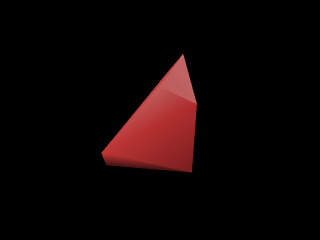

In [9]:
from glider.vehicle import Vehicle

v = Vehicle(num_vertices=10)

media.show_image(visualize.view_vehicle(v))

## The Test

The test is a drop from 80m.

The glider's score is determined by the distance travelled to the left or right.

In [10]:
import glider.simulation as simulation

test_xml_representation = simulation.drop_test_glider(v)

visualize.render_xml_to_collision(
    test_xml_representation,
    camera_name="fixed",
    show=True
)

The `fitness_func` renders this simulation, and returns the total distance travelled in the x-direction.

In [11]:
import glider.optimization as optimization

score = optimization.fitness_func(v)

print(f"Glider Score: {score}")

Glider Score: 3.1593347030484265


## Getting better gliders

The simplest way to get a better glider, is to try many random gliders. 

In the cell below, we create and test a population of 100 gliders.

In [12]:
population = [Vehicle(num_vertices=10) for _ in range(100)]

fitnesses = [optimization.fitness_func(v) for v in population]

This is what the top performers looked like:

""

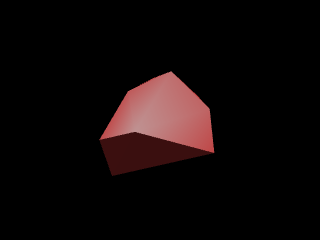

Fitness: 20.15057118163033


""

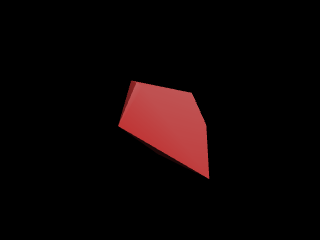

Fitness: 16.88164714475451


""

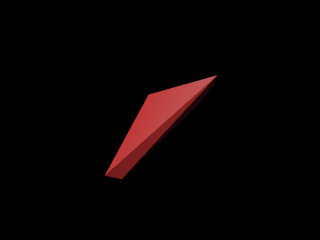

Fitness: 16.116303327571536


In [13]:
ranking = list(zip(population, fitnesses))
ranking.sort(key=lambda x: x[1], reverse=True)  # Sort by highest to lowest fitness

for glider, fitness in ranking[:3]:
    media.show_image(visualize.view_vehicle(glider))
    print(f"Fitness: {fitness}")

Graphing the distribution of the glider performances, we get:

<Axes: ylabel='Frequency'>

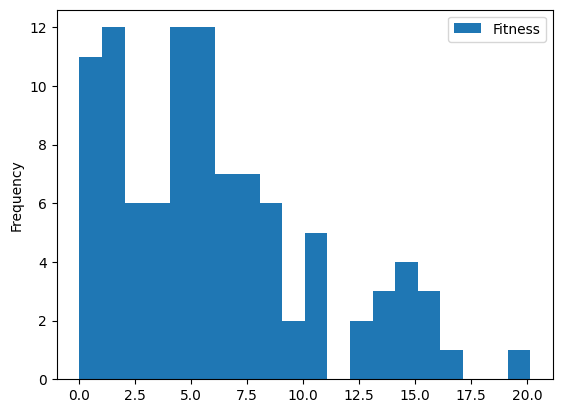

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(ranking, columns=["Vehicle", "Fitness"])
df.plot.hist(bins=20)

And the drop test for the best glider, looked like this:

In [15]:
winning_glider, fitness = ranking[0]

drop_test_xml = simulation.drop_test_glider(winning_glider)

visualize.render_xml_to_collision(
    drop_test_xml,
    camera_name="fixed",
    show=True
)

In [17]:
from io import BytesIO

import numpy as np
from PIL import Image

from glider.optimization import iterate_population, fitness_func, NUM_GENES
from glider.vehicle import VehicleConfig

population = [Vehicle(num_vertices=NUM_GENES) for _ in range(100)]

best_glider_frames = []
population_performance_frames = []
for i in range(300):
    ranking, population = iterate_population(
        population=population,
        survival_weight = 0.1,
        cloning_weight = 0.1,
    )

    if i % 10 == 0:
        print("Iteration:", i)
        winning_vehicle = population[0]
        print("Fitness:", fitness_func(winning_vehicle))

    df = pd.DataFrame(ranking, columns=["Vehicle", "Fitness"])
    df.plot.hist(bins=20)
    plt.xticks(range(0, 80, 10))
    plt.xlabel("Fitness")
    plt.yticks(range(0, 50, 10))
    plt.ylabel("Count")
    plt.legend().remove()

    buf = BytesIO()
    plt.savefig(buf, format="png")
    buf.seek(0)
    im = Image.open(buf, formats=["png"], )
    population_performance_frames.append(np.asarray(im)[:,:,:3])
    plt.close()

    best_glider_frames.append(visualize.view_vehicle(winning_vehicle))


Iteration: 0
Fitness: 20.100204514134564
Iteration: 10
Fitness: 28.257108674986952
Iteration: 20
Fitness: 40.16349234786112


In [18]:
media.show_video(population_performance_frames, fps=10)

In [19]:
media.show_video(best_glider_frames, fps=3)
best_glider_frames[0].shape

(240, 320, 3)

In [21]:
import glider.simulation as sim

test_xml_representation = simulation.drop_test_glider(winning_vehicle)

visualize.render_xml_to_collision(
    test_xml_representation,
    camera_name="fixed",
    show=True
)

In [ ]:
print(test_xml_representation)


<mujoco>
    <option density="1.2" viscosity="2e-05" wind="0 0 0"/>
    <worldbody>
        <light name="top" pos="0 0 5"/>
        <camera name="fixed" pos="0 -100 100" euler="40 0 0"/>
        <!-- Body -->
        
    <body name="body" pos="0 0 0" euler="0.0 0.0 0.0">
        <freejoint/>
        <!-- Main Wing -->
        <geom name="vehicle-wing" density="0.4" pos="-3.0 -3.0 -3.0" rgba="0.8 0.2 0.2 0.5" type="mesh" mesh="vehicle-wing-mesh"/>
        <camera name="track" pos="0 0 0" xyaxes="1 2 0 0 1 2" mode="track"/>
        
    </body>
    
        <!-- Landing Platform -->
        <body name="platform" pos="0 0 0">
            <geom name="platform-geom" type="box" size="1500 1500 1" rgba="1 1 1 1" pos="0 0 -80"/>
        </body>
    </worldbody>

    
            <asset>
                <mesh name="vehicle-wing-mesh" vertex="1.7435499014944003 1.777563880884164 3.153194511802174 4.121772566957089 0.38783417718230834 3.9235906445610866 0.1446363039499433 2.1341999859211924 1.2